In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.stats import norm, chi2

ticker = "SPY"
start = "2015-01-01"
end = None  # None = today

data = yf.download(ticker, start=start, end=end, auto_adjust=True, progress=False)

# ✅ Make sure px is a 1-D Series
px = data["Close"]
if isinstance(px, pd.DataFrame):
    px = px.iloc[:, 0]
px = px.dropna()
px.name = "Close"

ret = px.pct_change().dropna()
ret.name = "r"

ret.head()

Date
2015-01-05   -0.018060
2015-01-06   -0.009419
2015-01-07    0.012461
2015-01-08    0.017745
2015-01-09   -0.008013
Name: r, dtype: float64

In [16]:
def var_es_historical(returns: pd.Series, alpha: float = 0.01):
    q = returns.quantile(alpha)
    var = -q
    es = -returns[returns <= q].mean()
    return var, es

def var_es_normal(returns: pd.Series, alpha: float = 0.01):
    mu = returns.mean()
    sigma = returns.std(ddof=1)
    q = mu + sigma * norm.ppf(alpha)
    var = -(q)
    # ES for Normal: -E[r | r <= q]
    z = norm.ppf(alpha)
    es = -(mu - sigma * norm.pdf(z) / alpha)
    return var, es

def ewma_vol(returns: pd.Series, lam: float = 0.94):
    # RiskMetrics EWMA variance recursion
    r = returns.values
    v = np.zeros_like(r)
    v[0] = np.var(r[:50]) if len(r) > 50 else np.var(r)
    for t in range(1, len(r)):
        v[t] = lam * v[t-1] + (1 - lam) * r[t-1]**2
    return pd.Series(np.sqrt(v), index=returns.index, name="ewma_vol")

def var_es_ewma(returns: pd.Series, alpha: float = 0.01, lam: float = 0.94):
    mu = returns.mean()
    sigma_t = ewma_vol(returns, lam=lam)
    z = norm.ppf(alpha)
    var_t = -(mu + sigma_t * z)
    es_t = -(mu - sigma_t * norm.pdf(z) / alpha)
    return var_t, es_t

alpha = 0.01
window = 250  # rolling window ~1 year

# Rolling Historical + Normal
hist_var, hist_es, norm_var, norm_es = [], [], [], []
idx = ret.index[window:]

for i in range(window, len(ret)):
    w = ret.iloc[i-window:i]
    v1, e1 = var_es_historical(w, alpha=alpha)
    v2, e2 = var_es_normal(w, alpha=alpha)
    hist_var.append(v1); hist_es.append(e1)
    norm_var.append(v2); norm_es.append(e2)

hist_var = pd.Series(hist_var, index=idx, name="VaR_hist")
hist_es  = pd.Series(hist_es,  index=idx, name="ES_hist")
norm_var = pd.Series(norm_var, index=idx, name="VaR_norm")
norm_es  = pd.Series(norm_es,  index=idx, name="ES_norm")

# EWMA is time-varying; use full series, align to idx
ewma_var, ewma_es = var_es_ewma(ret, alpha=alpha, lam=0.94)
ewma_var = ewma_var.loc[idx].rename("VaR_ewma")
ewma_es  = ewma_es.loc[idx].rename("ES_ewma")

# Align realized returns
r = ret.loc[idx].rename("realized_return")

df = pd.concat([r, hist_var, norm_var, ewma_var, hist_es, norm_es, ewma_es], axis=1).dropna()
df.head()

,realized_return,VaR_hist,VaR_norm,VaR_ewma,ES_hist,ES_norm,ES_ewma
Date,,,,,,,
2015-12-31,-0.010003,0.02752,0.022517,0.023090,0.034019,0.025818,0.026536
2016-01-04,-0.013979,0.02752,0.022375,0.023067,0.034019,0.025659,0.026510
2016-01-05,0.001691,0.02752,0.022446,0.023693,0.034019,0.025737,0.027226
2016-01-06,-0.012614,0.02752,0.022417,0.022973,0.034019,0.025698,0.026402
2016-01-07,-0.023991,0.02752,0.022464,0.023362,0.034019,0.025735,0.026847


In [17]:
def kupiec_pof_test(exceptions: pd.Series, alpha: float):
    # exceptions: True if breach occurs
    x = int(exceptions.sum())
    n = int(exceptions.count())
    p = alpha
    phat = x / n if n > 0 else 0.0
    # Likelihood ratio
    # Handle edge cases
    if phat in [0.0, 1.0]:
        return np.nan, np.nan, x, n
    LR = -2 * (
        (n - x) * np.log((1 - p) / (1 - phat)) + x * np.log(p / phat)
    )
    pval = 1 - chi2.cdf(LR, df=1)
    return LR, pval, x, n

def christoffersen_independence_test(exceptions: pd.Series):
    e = exceptions.astype(int).values
    # transition counts
    n00 = n01 = n10 = n11 = 0
    for t in range(1, len(e)):
        if e[t-1] == 0 and e[t] == 0: n00 += 1
        if e[t-1] == 0 and e[t] == 1: n01 += 1
        if e[t-1] == 1 and e[t] == 0: n10 += 1
        if e[t-1] == 1 and e[t] == 1: n11 += 1
    # probabilities
    pi01 = n01 / (n00 + n01) if (n00 + n01) > 0 else 0
    pi11 = n11 / (n10 + n11) if (n10 + n11) > 0 else 0
    pi1  = (n01 + n11) / (n00 + n01 + n10 + n11) if (n00 + n01 + n10 + n11) > 0 else 0

    def safe_ll(a, b, p):
        # a successes, b failures
        if p == 0:
            return 0 if a == 0 else -np.inf
        if p == 1:
            return 0 if b == 0 else -np.inf
        return a*np.log(p) + b*np.log(1-p)

    ll_ind = safe_ll(n01 + n11, n00 + n10, pi1)
    ll_dep = safe_ll(n01, n00, pi01) + safe_ll(n11, n10, pi11)

    if not np.isfinite(ll_ind) or not np.isfinite(ll_dep):
        return np.nan, np.nan, (n00, n01, n10, n11)

    LR = -2 * (ll_ind - ll_dep)
    pval = 1 - chi2.cdf(LR, df=1)
    return LR, pval, (n00, n01, n10, n11)

def backtest_summary(df: pd.DataFrame, alpha: float):
    rows = []
    for col in ["VaR_hist", "VaR_norm", "VaR_ewma"]:
        # breach if realized return < -VaR (since VaR is positive loss)
        exc = df["realized_return"] < (-df[col])
        kup_LR, kup_p, x, n = kupiec_pof_test(exc, alpha=alpha)
        chr_LR, chr_p, trans = christoffersen_independence_test(exc)
        rows.append({
            "model": col,
            "n": n,
            "exceptions": x,
            "expected_exc": n * alpha,
            "kupiec_LR": kup_LR,
            "kupiec_pvalue": kup_p,
            "christoffersen_LR": chr_LR,
            "christoffersen_pvalue": chr_p
        })
    return pd.DataFrame(rows)

summary = backtest_summary(df, alpha=alpha)
summary

,model,n,exceptions,expected_exc,kupiec_LR,kupiec_pvalue,christoffersen_LR,christoffersen_pvalue
0,VaR_hist,2543,41,25.43,8.123176,4.370292e-03,12.528932,0.000401
1,VaR_norm,2543,72,25.43,57.592875,3.219647e-14,11.008362,0.000907
2,VaR_ewma,2543,61,25.43,36.108144,1.866651e-09,3.191511,0.074022


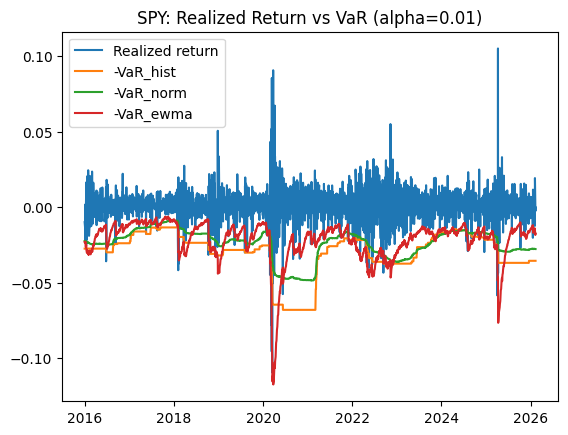

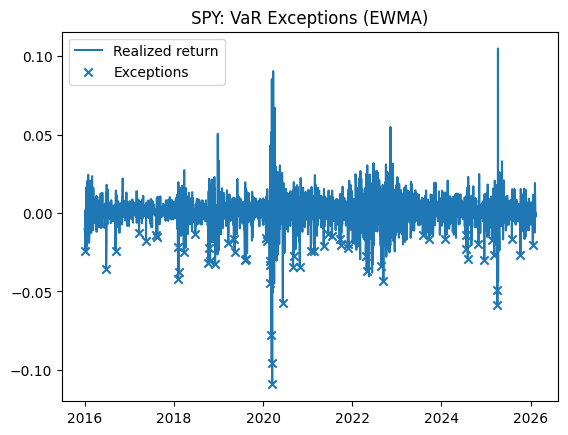

In [18]:
# Plot VaR time series vs returns
plt.figure()
plt.plot(df.index, df["realized_return"], label="Realized return")
plt.plot(df.index, -df["VaR_hist"], label="-VaR_hist")
plt.plot(df.index, -df["VaR_norm"], label="-VaR_norm")
plt.plot(df.index, -df["VaR_ewma"], label="-VaR_ewma")
plt.title(f"{ticker}: Realized Return vs VaR (alpha={alpha})")
plt.legend()
plt.show()

# Exception plot for one model (EWMA)
exc_ewma = df["realized_return"] < (-df["VaR_ewma"])
plt.figure()
plt.plot(df.index, df["realized_return"], label="Realized return")
plt.scatter(df.index[exc_ewma], df.loc[exc_ewma, "realized_return"], label="Exceptions", marker="x")
plt.title(f"{ticker}: VaR Exceptions (EWMA)")
plt.legend()
plt.show()

In [19]:
from pathlib import Path
import matplotlib.pyplot as plt

REPO = Path("/Users/justin/Desktop/Market-Risk-Quant-Portfolio")
outdir = REPO / "projects" / "01_var_es_backtesting" / "outputs"
outdir.mkdir(parents=True, exist_ok=True)

summary.to_csv(outdir / "backtest_summary.csv", index=False)

plt.figure()
plt.plot(df.index, df["realized_return"], label="Realized return")
plt.plot(df.index, -df["VaR_hist"], label="-VaR_hist")
plt.plot(df.index, -df["VaR_norm"], label="-VaR_norm")
plt.plot(df.index, -df["VaR_ewma"], label="-VaR_ewma")
plt.title(f"{ticker}: Realized Return vs VaR (alpha={alpha})")
plt.legend()
plt.tight_layout()
plt.savefig(outdir / "var_vs_return.png", dpi=200)
plt.close()

exc_ewma = df["realized_return"] < (-df["VaR_ewma"])
plt.figure()
plt.plot(df.index, df["realized_return"], label="Realized return")
plt.scatter(df.index[exc_ewma], df.loc[exc_ewma, "realized_return"], label="Exceptions", marker="x")
plt.title(f"{ticker}: VaR Exceptions (EWMA)")
plt.legend()
plt.tight_layout()
plt.savefig(outdir / "exceptions_ewma.png", dpi=200)
plt.close()

print(f"Saved outputs to: {outdir}")

Saved outputs to: /Users/justin/Desktop/Market-Risk-Quant-Portfolio/projects/01_var_es_backtesting/outputs
